In [81]:
import numpy as np
from scipy import stats
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.stats import norm,lognorm,expon
from sklearn.metrics import mean_absolute_error
from sklearn.cluster import KMeans
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg
import seaborn as sns
import pandas as pd

N=10000
alpha=0.1
n_experiments=1
lst_results_coverage=[]
lst_results_IOU=[]
X=np.zeros((N,3))
y=np.zeros(N)

for i in range(X.shape[0]):
    x_vec=norm.rvs(0,4, size=3)
    X[i,:]=x_vec
    y[i]=3*x_vec[0]+0.5*x_vec[1]+x_vec[2]+norm.rvs(0,np.sum(np.abs(x_vec)), size=1)[0]

plt.rcParams["figure.figsize"] = (15,8)
plt.rcParams.update({'font.size': 25})
sns.set_style("darkgrid", {'axes.grid' : True})
X,y


(array([[ 2.74250359,  4.10627542, -2.38836568],
        [ 1.27833526, -2.04740241, -4.05254385],
        [ 0.08652303,  5.59249677,  3.31060731],
        ...,
        [ 3.018086  , -5.86002918, -4.56981521],
        [-2.28947261, -4.56488682,  4.04713091],
        [-0.50505224,  3.18421273, -3.31223739]]),
 array([-11.66682136, -10.66647272,   5.79846932, ..., -12.79232177,
        -18.24161443,  -6.99746067]))

In [82]:
#Split the dataset in 3 mutually exclusive datasets, train, calibatrion and evaluation (for assessement)
# 50%,25%,25%

def train_cal_test_split(X,y,random_state=22):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=random_state)
    X_cal,X_val,y_cal,y_val= train_test_split(X_test, y_test, test_size=0.5, random_state=random_state)
    
    return X_train,y_train,X_cal,y_cal,X_val,y_val

X_train,y_train,X_cal,y_cal,X_val,y_val=train_cal_test_split(X,y,random_state=22)

In [83]:
def calculate_performance(lower_bound,upper_bound,y_true):
    #calculate coverage
    
    out_of_bounds=0
    N=len(y_true)
    
    for i in range(N):
        if y_true[i]<lower_bound[i] or y_true[i]>upper_bound[i]:
            out_of_bounds+=1
        
    
    
    return 1-out_of_bounds/N

def summary_statistics(arr):
    # calculates summary statistics from array
    
    return [np.min(arr),np.max(arr),np.mean(arr), np.std(arr),np.quantile(arr,0.25),np.quantile(arr,0.5),np.quantile(arr,0.75),np.quantile(arr,0.75)-np.quantile(arr,0.25)]

def calibrate_qhat(y_true,lower_bound,upper_bound,alpha=0.1):
    # Calculate q_yhat for QR (CQR)
    
    N=len(y_true)
    s=np.amax([lower_bound-y_true,y_true-upper_bound],axis=0)
    q_yhat=np.quantile(s,1-alpha)
    
    return q_yhat

def set_1D_intersection(arr1,arr2):
    # Calculate the intersection between two 1D intervals [a,b] [c,d]
    
    r=[] # intersection result
    
    if arr2[0] > arr1[1] or arr1[0]>arr2[1]:
        
        return r
    else:
        r.append(max(arr1[0],arr2[0]))
        r.append(min(arr1[1],arr2[1]))
        
    return r

def set_1D_union(arr1,arr2):
    # Calculates the union between two 1D intervals [a,b] [c,d]
    
    r=[] # union result
    
    r.append(min(arr1[0],arr2[0]))
    r.append(max(arr1[1],arr2[1]))
        
    return r

def intersection_over_union1D(arr1,arr2):
    # Computes the overlap over union. Lies in (0,1)
    
    inter=set_1D_intersection(arr1,arr2)
    union=set_1D_union(arr1,arr2)
    
    if not inter:
        return 0
    
    return ((inter[1]-inter[0])/(union[1]-union[0]))

def permutation_importance(model,X_cal,y_cal,n_repeats):
    # model: trained ML model
    # X_train: Explanatory variables training set
    # y_train: Response variables for training
    # X_cal: Explanatory variables for evaluation (calculate decrease in importance)
    # y_cal: Response variables for evaluation (calculate decrease in importance)
    # n_repeats: Number of repetitions to shuffle each column and then average the difference
    
    n_features=X_cal.shape[1]
    feature_importances=np.zeros((n_repeats,n_features))
    true_indexes = np.arange(n_features)
    
    for j in range(n_features):
        for i in range(n_repeats):
            X_cal_permuted=np.copy(X_cal)
            X_cal_permuted[:,j]=resample(X_cal_permuted[:,j])
            y_pred=model.predict(X_cal)
            y_pred_permuted=model.predict(X_cal_permuted)
            mae= mean_absolute_error(y_pred,y_cal)
            mae_perm=mean_absolute_error(y_pred_permuted,y_cal)
            diff=np.abs(mae_perm-mae)
            feature_importances[i,j]= diff
        
    return np.mean(feature_importances,axis=0)

def compute_IOU(lower_bound,upper_bound,data_matrix,alpha=0.1):
    N=data_matrix.shape[0]
    IOU_scores=[]
    
    for i in range(N):
        x_vec=data_matrix[i]
        true_lower=3*x_vec[0]+x_vec[1]+0.5*x_vec[2]+norm.ppf(alpha/2,0,np.abs(np.sum(data_matrix[i])))
        true_upper=3*x_vec[0]+x_vec[1]+0.5*x_vec[2]+norm.ppf(1-alpha/2,0,np.sum(np.abs(data_matrix[i])))
        IOU_scores.append(intersection_over_union1D([true_lower,true_upper],[lower_bound[i],upper_bound[i]]))
        
    return IOU_scores 

def optimized_kmeans(X,desired_variance,feature_importance,max_number_of_clusters):
    
    scores=[]
    
    mean_point=np.mean(X*feature_importance,axis=0)
    SSE=np.sum((X*feature_importance-mean_point)**2)
    i=1
    variance=0
    
    while variance < desired_variance and i< max_number_of_clusters:
        km =  KMeans(n_clusters=i+1, random_state=0).fit(X*feature_importance)
        centroids=km.cluster_centers_
        
        clusters=km.labels_
        
        SSE_between=0
        
        for j in range(len(np.unique(clusters))):
            n_k=X[clusters==j,:].shape[0]
            
            SSE_between+=n_k*np.sum((centroids[j]-mean_point)**2)
        
        variance=SSE_between/SSE
        
        scores.append([i+1,variance])
        i+=1
    
    scores=np.array(scores)
    
    best_k=i
    plt.axvline(x=best_k, color='r', linestyle='--')
    plt.plot(scores[:,0],scores[:,1])
    plt.xlabel('#clusters')
    plt.ylabel('Explained variance')
    plt.show()
    
    km =  KMeans(n_clusters=i, random_state=0).fit(X*feature_importance)
    
    return km,best_k

def CQR_qhats_per_group(X_cal,y_cal,upper_bound,lower_bound,desired_variance,max_number_of_clusters,feature_importance,alpha=0.1):
    
    #models=QuantileRegressionModel(X_train,y_train,T)
    km,best_k=optimized_kmeans(X_cal,desired_variance,feature_importance,max_number_of_clusters)
    q_hats=np.zeros(best_k)
    nrows=X_cal.shape[0]
    clusters=km.predict(X_cal*feature_importance)
        
    scores=[]
    
    for i in range(best_k):
        scores.append([])


    for i in range(nrows):
        scores[clusters[i]].append(max(lower_bound[i]-y_cal[i],y_cal[i]-upper_bound[i]))

    for i in range(best_k):
        q_hats[i]=np.quantile(scores[i],1-alpha)

    
    return km,q_hats

def ConditionalCQR_calculate_bounds(model_lower,model_upper,q_hats,km,X_val,feature_importance):
    
    upper_bound=model_upper.predict(X_val)
    lower_bound=model_lower.predict(X_val)
    print(lower_bound)
    
    nrows=X_val.shape[0]
    assigned_cluster=km.predict(X_val*feature_importance)
    lower_bound_final=np.zeros(nrows)
    upper_bound_final=np.zeros(nrows)
    
    for i in range(nrows):
        lower_bound_final[i]=lower_bound[i]-q_hats[assigned_cluster[i]]
        upper_bound_final[i]=upper_bound[i]+q_hats[assigned_cluster[i]]
        

            
    return lower_bound_final,upper_bound_final




In [84]:
df_train = pd.DataFrame({'x1':X_train[:,0],'x2':X_train[:,1],'x3':X_train[:,2], 'y':y_train})
model= QuantReg(df_train['y'],df_train[["x1","x2","x3"]]).fit(0.5)

feature_importance=permutation_importance(model,X_cal,y_cal,100)

feature_importance

array([7.89759741, 0.43561504, 1.16128289])

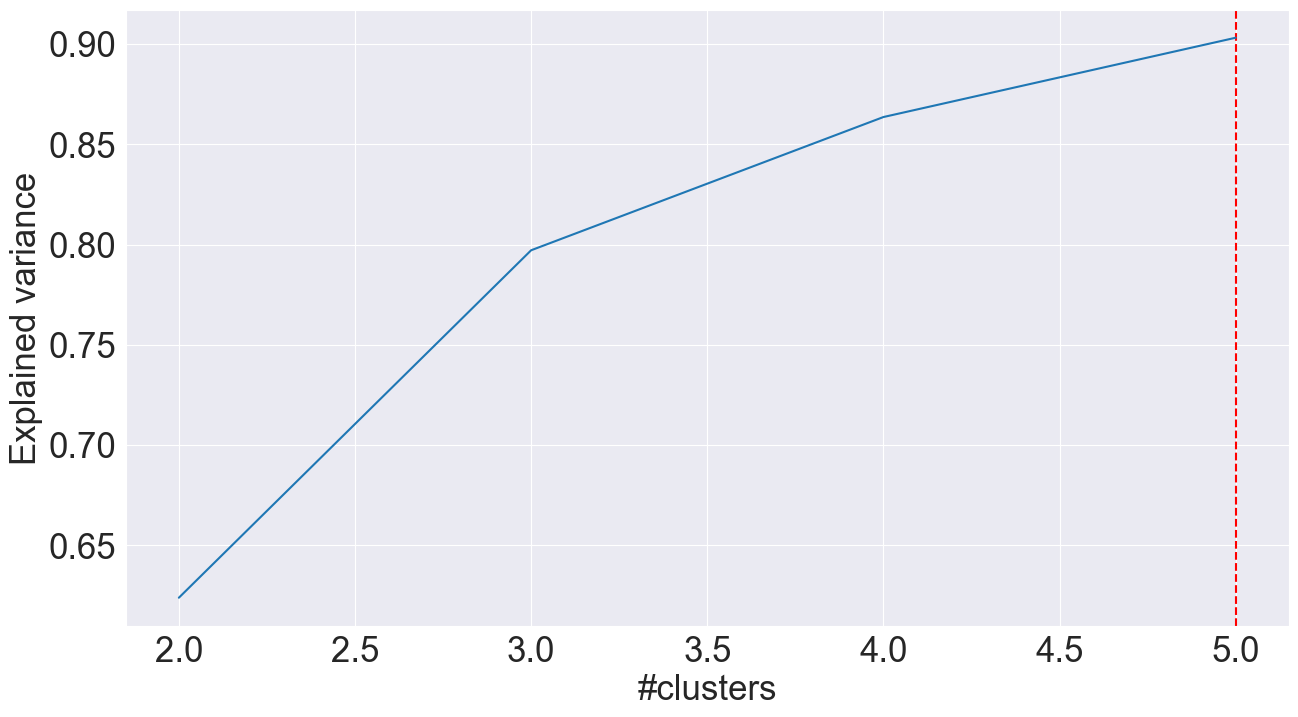

[ 13.40019367 -14.05299108  -0.28190006 ...  27.40890624  -5.56462352
  14.606191  ]


([[0.8908, 0.8908, 0.8908, 0.0, 0.8908, 0.8908, 0.8908, 0.0],
  [0.8944, 0.8944, 0.8944, 0.0, 0.8944, 0.8944, 0.8944, 0.0]],
 [[0.058630664447717855,
   0.9953513607821535,
   0.5847422939740907,
   0.19811472845086445,
   0.43207782913518733,
   0.5859300650048562,
   0.741204568612356,
   0.3091267394771686],
  [0.07625490787614446,
   0.9934663138474488,
   0.6026940627541413,
   0.18976351095659497,
   0.46400622485428106,
   0.6002947527252397,
   0.7509163511940589,
   0.2869101263397778]])

In [85]:

coverage_CQR=[]
CQR_scores=[]
coverage_ICQR=[]
ICQR_scores=[]

for i in range(n_experiments):
    df_train = pd.DataFrame({'x1':X_train[:,0],'x2':X_train[:,1],'x3':X_train[:,2], 'y':y_train})
    reg_lower= QuantReg(df_train['y'],df_train[["x1","x2","x3"]]).fit(alpha/2)
    reg_upper= QuantReg(df_train['y'],df_train[["x1","x2","x3"]]).fit(1-alpha/2)
    lower_bound_cal=reg_lower.predict(X_cal)
    upper_bound_cal=reg_upper.predict(X_cal)
    lower_bound_val=reg_lower.predict(X_val)
    upper_bound_val=reg_upper.predict(X_val)
    
    qhat=calibrate_qhat(y_cal,lower_bound_cal,upper_bound_cal,alpha)
    km,q_hats=CQR_qhats_per_group(X_cal,y_cal,upper_bound_cal,lower_bound_cal,0.9,100,feature_importance,alpha)
    ICQR_lower_bound_val,ICQR_upper_bound_val=ConditionalCQR_calculate_bounds(reg_lower,reg_upper,q_hats,km,X_val,feature_importance)
    coverage_QR.append(calculate_performance(lower_bound_val,upper_bound_val,y_val))
    coverage_CQR.append(calculate_performance(lower_bound_val-qhat,upper_bound_val+qhat,y_val))
    coverage_ICQR.append(calculate_performance(ICQR_lower_bound_val,ICQR_upper_bound_val,y_val))
    CQR_scores.append(compute_IOU(lower_bound_val-qhat,upper_bound_val+qhat,X_val,alpha))
    ICQR_scores.append(compute_IOU(ICQR_lower_bound_val,ICQR_upper_bound_val,X_val,alpha))
    
lst_results_coverage.append(summary_statistics(coverage_CQR))
lst_results_coverage.append(summary_statistics(coverage_ICQR))
lst_results_IOU.append(summary_statistics(CQR_scores))
lst_results_IOU.append(summary_statistics(ICQR_scores))
lst_results_coverage,lst_results_IOU
    

In [86]:


df_coverages=pd.DataFrame(lst_results_coverage,columns=['min','max','mean','std','Q1','median','Q3','IQR'])
df_coverages

,min,max,mean,std,Q1,median,Q3,IQR
0,0.8908,0.8908,0.8908,0.0,0.8908,0.8908,0.8908,0.0
1,0.8944,0.8944,0.8944,0.0,0.8944,0.8944,0.8944,0.0


In [87]:
print(df_coverages.to_latex(index=False)) 

\begin{tabular}{rrrrrrrr}
\toprule
   min &    max &   mean &  std &     Q1 &  median &     Q3 &  IQR \\
\midrule
0.8908 & 0.8908 & 0.8908 &  0.0 & 0.8908 &  0.8908 & 0.8908 &  0.0 \\
0.8944 & 0.8944 & 0.8944 &  0.0 & 0.8944 &  0.8944 & 0.8944 &  0.0 \\
\bottomrule
\end{tabular}



C:\Users\Martim Sousa\AppData\Local\Temp\ipykernel_11556\1941390230.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_coverages.to_latex(index=False))


In [88]:
df_IOU=pd.DataFrame(lst_results_IOU,columns=['min','max','mean','std','Q1','median','Q3','IQR'])
df_IOU

,min,max,mean,std,Q1,median,Q3,IQR
0,0.058631,0.995351,0.584742,0.198115,0.432078,0.585930,0.741205,0.309127
1,0.076255,0.993466,0.602694,0.189764,0.464006,0.600295,0.750916,0.286910


In [89]:
print(df_IOU.to_latex(index=False)) 

\begin{tabular}{rrrrrrrr}
\toprule
     min &      max &     mean &      std &       Q1 &   median &       Q3 &      IQR \\
\midrule
0.058631 & 0.995351 & 0.584742 & 0.198115 & 0.432078 & 0.585930 & 0.741205 & 0.309127 \\
0.076255 & 0.993466 & 0.602694 & 0.189764 & 0.464006 & 0.600295 & 0.750916 & 0.286910 \\
\bottomrule
\end{tabular}



C:\Users\Martim Sousa\AppData\Local\Temp\ipykernel_11556\2173106946.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_IOU.to_latex(index=False))
